# Least square

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
import cvxopt
from cvxopt import matrix
from cvxopt import solvers

sampx = np.loadtxt('polydata_data_sampx.txt') 
sampy = np.loadtxt('polydata_data_sampy.txt')
polyx = np.loadtxt('polydata_data_polyx.txt') 
polyy = np.loadtxt('polydata_data_polyy.txt')

#5th orders
K = 5
def PHI(K,data):
    phi = []
    for i in range(0, K + 1):
        phi_inter = data ** i
        phi.append(phi_inter)
    phi = np.mat(phi)
    return phi
phisamp = PHI(K,sampx)
phiploy = PHI(K,polyx)

def plots(samp_x,samp_y,ploy_x,ploy_y,predict,label='name'):
    pl.plot(samp_x,samp_y,'bo',label='samples')
    pl.plot(ploy_x,predict,label=label)
    pl.plot(ploy_x,ploy_y,label='True function')
    pl.title(label)
    pl.legend() 
    pl.savefig(label+"1.jpg")
    pl.close()
    return
def plots_BR(samp_x,samp_y,ploy_x,ploy_y,predict):
    pl.plot(samp_x,samp_y,'bo',label='samples')
    pl.plot(ploy_x,predict[0],label='function')
    pl.errorbar(ploy_x,ploy_y,np.sqrt(np.diag(predict[1])),label='True function')
    pl.title('BR')
    pl.legend()
    pl.savefig("BR1.jpg")
    pl.show()

def MSE(trueoutput, learnedoutput):
    trueoutput = trueoutput.reshape(len(trueoutput),1)
    learnedoutput = learnedoutput.reshape(len(learnedoutput),1)
    return np.sum(np.square(trueoutput-learnedoutput))/np.size(trueoutput)

# Least square

In [9]:
#LS
def poly_LS(phi,y):
    return (phi * np.transpose(phi)).I * phi * np.transpose(np.mat(y))
ls = poly_LS(phisamp,sampy)
print('Estimated parameters: ',ls)
predict = np.transpose(PHI(K,polyx)) * ls
plots(sampx,sampy,polyx,polyy,predict,'LS')
MSE(polyy,predict)

Estimated parameters:  [[  6.15769274e-01]
 [  1.10406633e+00]
 [  1.33022515e+00]
 [ -6.93228415e-01]
 [  9.17835000e-04]
 [ -6.86117508e-01]]


0.40864388356985265

# Regularized LS

In [10]:
#RLS
def poly_RLS(phi,y,Labmda):
    return ((phi * np.transpose(phi) + Labmda * np.eye(np.shape(phi)[0])).I) * phi * np.transpose(np.mat(y))
rls = poly_RLS(phisamp,sampy,1)
print('Estimated parameters: ',rls)
predict = np.transpose(PHI(K,polyx)) * rls
plots(sampx,sampy,polyx,polyy,predict,'RLS')
MSE(polyy,predict)

Estimated parameters:  [[ 0.68185088]
 [ 0.8032859 ]
 [ 1.17035187]
 [-0.43660814]
 [ 0.04726588]
 [-0.73411837]]


0.4086325708836992

# LASSO

In [11]:
#LASSO
def poly_LASSO(phi,y,Lambda):
    phiphiT = phi * np.transpose(phi)
    H = np.vstack(((np.hstack((phiphiT,-1 * phiphiT))),
              (np.hstack((-1 * phiphiT, phiphiT)))))    
    phiy = np.vstack((phi * np.transpose(np.mat(y)),-1 * phi * np.transpose(np.mat(y))))
    f = Lambda * np.ones(phiy.shape) - phiy
    G = np.eye(len(f))*-1
    h = np.zeros(len(f))
    sol = solvers.qp(matrix(H),matrix(f),matrix(G),matrix(h))
    x = sol['x']
    theta = x[:int(len(x)/2)]- x[int(len(x)/2):]
    return theta
lasso = poly_LASSO(phisamp,sampy,1)
print('Estimated parameters: ',lasso)
predict = np.dot(np.transpose(PHI(K,polyx)),lasso)
plots(sampx,sampy,polyx,polyy,predict,'LASSO')
MSE(polyy,predict)

     pcost       dcost       gap    pres   dres
 0: -1.0534e+03 -1.0396e+03  2e+01  9e+00  3e-16
 1: -1.0398e+03 -1.0385e+03  2e+00  8e-01  2e-16
 2: -1.0376e+03 -1.0376e+03  1e-01  4e-02  2e-16
 3: -1.0375e+03 -1.0375e+03  6e-03  3e-16  7e-17
 4: -1.0375e+03 -1.0375e+03  3e-04  3e-16  1e-16
Optimal solution found.
Estimated parameters:  [ 6.26e-01]
[ 5.91e-01]
[ 1.31e+00]
[-1.89e-01]
[ 6.55e-04]
[-7.92e-01]



0.47460685881917192

# RR

In [12]:
#RR
def poly_RR(phi,y):
    A = np.vstack(((np.hstack((-1 * np.transpose(phi),-1*np.eye(np.shape(np.transpose(phisamp))[0])))),
              (np.hstack((np.transpose(phi), -1*np.eye(np.shape(np.transpose(phisamp))[0]))))))  
    b = np.hstack((-y,y))
    f = np.hstack((np.zeros(np.shape(np.transpose(phisamp))[1]),np.ones(np.shape(np.transpose(phisamp))[0])))
    sol = solvers.lp(matrix(f),matrix(A),matrix(b))
    theta = np.array(sol['x'][:np.shape(np.transpose(phisamp))[1]])   
    return theta
rr = poly_RR(phisamp,sampy)
print('Estimated parameters: ',rr)
predict = np.dot(np.transpose(PHI(K,polyx)),rr)
plots(sampx,sampy,polyx,polyy,predict,'RR')
MSE(polyy,predict)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.5527e-15  3e+02  9e-01  2e-15  1e+00
 1:  3.9223e+01  3.9399e+01  6e+01  2e-01  4e-15  4e-01
 2:  5.8134e+01  5.8186e+01  1e+01  4e-02  3e-14  1e-01
 3:  6.3314e+01  6.3326e+01  2e+00  7e-03  4e-14  2e-02
 4:  6.4289e+01  6.4291e+01  4e-01  1e-03  7e-14  3e-03
 5:  6.4452e+01  6.4452e+01  7e-02  2e-04  7e-14  6e-04
 6:  6.4483e+01  6.4483e+01  3e-03  8e-06  1e-13  2e-05
 7:  6.4484e+01  6.4484e+01  3e-05  8e-08  6e-14  2e-07
Optimal solution found.
Estimated parameters:  [[ 1.01563532]
 [ 1.86713473]
 [ 0.26492436]
 [-1.70405034]
 [ 0.34503254]
 [-0.40769652]]


0.76804615051335501

# Bayesian regression

Estimated parameters:  [[ 31.28034953]
 [ 28.6412853 ]
 [ 26.19000582]
 [ 23.91590465]
 [ 21.80880162]
 [ 19.85893382]
 [ 18.05694668]
 [ 16.39388496]
 [ 14.86118383]
 [ 13.45065986]
 [ 12.15450208]
 [ 10.96526301]
 [  9.8758497 ]
 [  8.87951475]
 [  7.96984735]
 [  7.14076433]
 [  6.38650115]
 [  5.701603  ]
 [  5.08091577]
 [  4.51957714]
 [  4.01300756]
 [  3.55690134]
 [  3.14721763]
 [  2.78017149]
 [  2.45222493]
 [  2.1600779 ]
 [  1.90065937]
 [  1.67111836]
 [  1.46881493]
 [  1.29131127]
 [  1.13636271]
 [  1.00190874]
 [  0.88606406]
 [  0.78710964]
 [  0.7034837 ]
 [  0.63377278]
 [  0.57670276]
 [  0.5311299 ]
 [  0.4960319 ]
 [  0.47049888]
 [  0.45372445]
 [  0.44499674]
 [  0.44368944]
 [  0.44925281]
 [  0.46120474]
 [  0.47912178]
 [  0.50263014]
 [  0.5313968 ]
 [  0.56512047]
 [  0.60352264]
 [  0.64633864]
 [  0.69330868]
 [  0.74416882]
 [  0.7986421 ]
 [  0.85642948]
 [  0.91720094]
 [  0.98058648]
 [  1.04616719]
 [  1.11346622]
 [  1.1819399 ]
 [  1.25096869]
 

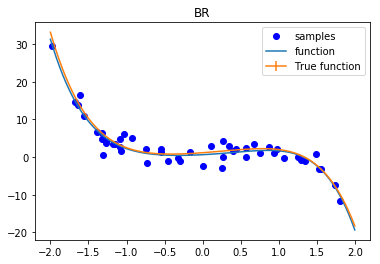

0.40823651820263246

In [13]:
#Bayesian regression
def posterior(y,phi,alpha,sigma):
    thelta_cov = (1/alpha * np.eye(np.shape(phi)[0]) + 1/(sigma ** 2) * phi * np.transpose(phi)).I
    thelta_mean = 1/(sigma ** 2) * thelta_cov * phi * np.transpose(np.mat(y))
    return thelta_mean,thelta_cov
def poly_BR(x,thelta_mean,thelta_cov,K):
    thelta_mean_star = np.transpose(PHI(K,x)) * thelta_mean
    thelta_cov_star = np.transpose(PHI(K,x)) * thelta_cov * thelta_cov * PHI(K,x)
    return thelta_mean_star,thelta_cov_star
post = posterior(sampy, phisamp, 0.1, 0.1)
br = poly_BR(polyx,post[0],post[1],K)
print('Estimated parameters: ',br[0])
plots_BR(sampx,sampy,polyx,polyy,br)
MSE(polyy,br[0])

In [16]:
# Experiment with hyperparameters
Lambda = np.linspace(0.1,5,15)
mse_rls = []
for i in range(0,len(Lambda)):
    rls = poly_RLS(phisamp,sampy,Lambda[i])   
    predict = np.transpose(PHI(K,polyx)) * rls    
    mse_rls.append(MSE(polyy,predict))
Lambda[mse_rls.index(min(mse_rls))]

0.45000000000000007

In [116]:
mse_lasso = []
for i in range(0,len(Lambda)):
    lasso = poly_LASSO(phisamp,sampy,Lambda[i])
    np.dot(np.transpose(PHI(K,polyx)),lasso)    
    mse_lasso.append(MSE(polyy,predict))
mse_lasso[mse_rls.index(min(mse_rls))]

     pcost       dcost       gap    pres   dres
 0: -1.0415e+03 -1.0378e+03  3e+01  6e+00  2e-03
 1: -1.0397e+03 -1.0412e+03  2e+00  1e-15  1e-16
 2: -1.0410e+03 -1.0411e+03  1e-01  5e-16  2e-16
 3: -1.0411e+03 -1.0411e+03  3e-03  3e-16  2e-16
 4: -1.0411e+03 -1.0411e+03  2e-04  4e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0438e+03 -1.0333e+03  3e+01  7e+00  1e-03
 1: -1.0363e+03 -1.0404e+03  4e+00  8e-16  4e-16
 2: -1.0395e+03 -1.0398e+03  4e-01  5e-16  2e-16
 3: -1.0396e+03 -1.0396e+03  2e-02  3e-16  5e-16
 4: -1.0396e+03 -1.0396e+03  7e-04  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0491e+03 -1.0396e+03  1e+01  8e+00  1e-16
 1: -1.0396e+03 -1.0389e+03  1e+00  7e-01  2e-16
 2: -1.0383e+03 -1.0383e+03  7e-02  3e-02  4e-16
 3: -1.0382e+03 -1.0382e+03  3e-03  2e-16  5e-16
 4: -1.0382e+03 -1.0382e+03  2e-04  2e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 

0.40864388356985265

In [63]:
mu = np.linspace(1,10,10)
ceta = np.linspace(1,5,5)
mse_br = np.zeros((10,5))
for i in range(0,len(mu)):
    for j in range(0,len(ceta)):
        post = posterior(sampy, phisamp, mu[i], ceta[j])
        br = poly_BR(polyx,post[0],post[1],K)   
        mse_br[i,j] = (MSE(polyy,br[0]))
re = np.where(mse_br == np.min(mse_br))
print(mu[re[0]])
print(np.square(ceta[re[1]]))        

[ 2.  8.]
[ 1.  4.]


array([ 1.,  4.])

In [58]:
np.square

(array([1, 7], dtype=int64), array([0, 1], dtype=int64))